
# Gaussian Mixture Model Selection

This example shows that model selection can be performed with Gaussian Mixture
Models (GMM) using `information-theory criteria`. Model selection
concerns both the covariance type and the number of components in the model.

In this case, both the Akaike Information Criterion (AIC) and the Bayes
Information Criterion (BIC) provide the right result, but we only demo the
latter here.  Its a small change to do AIC, left to the student as an exercise :)

Generally AIC penalizes model complexity less than BIC; also BIC probably does better as $\lim N \to \infty$ and AIC may be better at smaller sample sizes


## Data generation

We generate two components (each one containing `n_samples`) by randomly
sampling the standard normal distribution as returned by `numpy.random.randn`.
One component is kept spherical yet shifted and re-scaled. The other one is
deformed to have a more general covariance matrix.



In [1]:
import numpy as np

n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

We can visualize the different components:



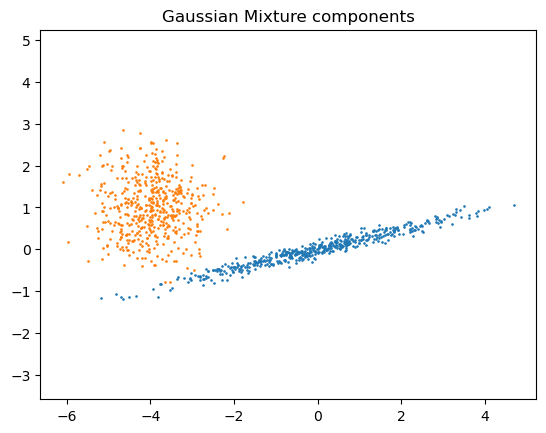

In [2]:
import matplotlib.pyplot as plt

plt.scatter(component_1[:, 0], component_1[:, 1], s=0.8)
plt.scatter(component_2[:, 0], component_2[:, 1], s=0.8)
plt.title("Gaussian Mixture components")
plt.axis("equal")
plt.show()

## Model training and selection

We vary the number of components from 1 to 6 and the type of covariance
parameters to use:

- `"full"`: each component has its own general covariance matrix.
- `"tied"`: all components share the same general covariance matrix.
- `"diag"`: each component has its own diagonal covariance matrix.
- `"spherical"`: each component has its own single variance.

We score the different models and keep the best model (the lowest BIC). This
is done by using [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and a
user-defined score function which returns the negative BIC score, as
GridSearchCV is designed to **maximize** a
score (maximizing the negative BIC is equivalent to minimizing the BIC).

The best set of parameters and estimator are stored in `best_parameters_` and
`best_estimator_`, respectively.



In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


# this is your scoring function for Grid Search
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# this is the parameters, of which the Grid Search 
# tries all possible combinations... 
# e.g. full+1component, full+2, ... full+7, diag+1, diag+2... 
param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

# docs at
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search = GridSearchCV(gmm_bic_score(estimator, X),param_grid=param_grid, cv=3)
grid_search.fit(X)

NameError: name 'estimator' is not defined

## Plot the BIC scores

To ease the plotting we can create a `pandas.DataFrame` from the results of
the cross-validation done by the grid search. We re-inverse the sign of the
BIC score to show the effect of minimizing it.



In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

In [ ]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In the present case, the model with 2 components and full covariance (which
corresponds to the true generative model) has the lowest BIC score and is
therefore selected by the grid search.

## Plot the best model

We plot an ellipse to show each Gaussian component of the selected model. For
such purpose, one needs to find the eigenvalues of the covariance matrices as
returned by the `covariances_` attribute. The shape of such matrices depends
on the `covariance_type`:

- `"full"`: (`n_components`, `n_features`, `n_features`)
- `"tied"`: (`n_features`, `n_features`)
- `"diag"`: (`n_components`, `n_features`)
- `"spherical"`: (`n_components`,)



In [ ]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()